# What drives the price of a car?

The goal of this analysis is to determine which factors most significantly affect the price of a used car, enabling the client a used car dealership to optimize inventory and pricing strategies based on consumer preferences and valuations.

This analysis follows the CRISP-DM framework and includes data cleaning, feature engineering, exploratory data analysis, and predictive modeling. Key findings will be presented to support the dealership's bussines decisions.

###### The original dataset from Kaggle contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.


### Library:

In [1]:
import pandas as pd  # For data manipulation
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For visualizations
import seaborn as sns  # For statistical data visualization
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  # For model training
from sklearn.linear_model import LinearRegression, Ridge, Lasso  # For regression models
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # For model evaluation
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Data Undertanding

In [2]:
data_path = 'vehicles.csv'  
vehicles_df = pd.read_csv(data_path)

In [3]:
vehicles_df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [4]:
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [5]:
vehicles_df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


## Data Understanding 

In [6]:
# Check missing values in each column
vehicles_df.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

There are 426.880 entries and significant missing values in columns like condition, cylinder, VIN, drive, size and paint color.

In [7]:
# Handle missing values
# Fill missing year values with the median
vehicles_df['year'].fillna(vehicles_df['year'].median(), inplace=True)

# Fill missing odometer values with the median
vehicles_df['odometer'].fillna(vehicles_df['odometer'].median(), inplace=True)

# Drop rows with missing target (price)
vehicles_df.dropna(subset=['price'], inplace=True)
# Print
vehicles_df.isnull().sum()

id                   0
region               0
price                0
year                 0
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer             0
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [8]:
# Fill missing values in relevant categorical columns with 'unknown'
categorical_columns = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 
                       'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']
vehicles_df[categorical_columns] = vehicles_df[categorical_columns].fillna('unknown')

# Print columns
print(vehicles_df[categorical_columns].isnull().sum())

manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
dtype: int64


### Data Preparation

Calculate car age creating a new column for car age by subtracting the year column from the current year, 2024.
Since the VIN number doesn't contribute to price prediction, It'll be remove it.

In [9]:
# Calculate car age
current_year = 2024
vehicles_df['car_age'] = current_year - vehicles_df['year']

# Drop the VIN column
vehicles_df.drop(columns=['VIN'], inplace=True)

# Print
print(vehicles_df.head())


           id                  region  price    year manufacturer    model  \
0  7222695916                prescott   6000  2013.0      unknown  unknown   
1  7218891961            fayetteville  11900  2013.0      unknown  unknown   
2  7221797935            florida keys  21000  2013.0      unknown  unknown   
3  7222270760  worcester / central MA   1500  2013.0      unknown  unknown   
4  7210384030              greensboro   4900  2013.0      unknown  unknown   

  condition cylinders     fuel  odometer title_status transmission    drive  \
0   unknown   unknown  unknown   85548.0      unknown      unknown  unknown   
1   unknown   unknown  unknown   85548.0      unknown      unknown  unknown   
2   unknown   unknown  unknown   85548.0      unknown      unknown  unknown   
3   unknown   unknown  unknown   85548.0      unknown      unknown  unknown   
4   unknown   unknown  unknown   85548.0      unknown      unknown  unknown   

      size     type paint_color state  car_age  
0  unkn

Since my system is running out of memory while trying to process the one-hot encoding, I'll try to only apply it to a set of columns that for me will be the most impactful using a smaller set of categorical columns

In [10]:
# Encode categorical variables
# Smaller set of categorical columns to one-hot encode
limited_columns_to_encode = ['manufacturer', 'fuel', 'transmission']

# Apply one-hot encoding to the columns
vehicles_df = pd.get_dummies(vehicles_df, columns=limited_columns_to_encode, drop_first=True)
print(vehicles_df.head())


           id                  region  price    year    model condition  \
0  7222695916                prescott   6000  2013.0  unknown   unknown   
1  7218891961            fayetteville  11900  2013.0  unknown   unknown   
2  7221797935            florida keys  21000  2013.0  unknown   unknown   
3  7222270760  worcester / central MA   1500  2013.0  unknown   unknown   
4  7210384030              greensboro   4900  2013.0  unknown   unknown   

  cylinders  odometer title_status    drive  ... manufacturer_volkswagen  \
0   unknown   85548.0      unknown  unknown  ...                   False   
1   unknown   85548.0      unknown  unknown  ...                   False   
2   unknown   85548.0      unknown  unknown  ...                   False   
3   unknown   85548.0      unknown  unknown  ...                   False   
4   unknown   85548.0      unknown  unknown  ...                   False   

  manufacturer_volvo fuel_electric fuel_gas  fuel_hybrid  fuel_other  \
0              False

In [52]:
# One-hot encode categorical columns that were missed 
categorical_columns = ['fuel_type', 'transmission_type', 'drive', 'manufacturer', 'condition', 'cylinders', 'title_status', 'size', 'type', 'paint_color']

# Apply one-hot encoding
filtered_df = pd.get_dummies(filtered_df, columns=categorical_columns, drop_first=True)

# Make sure there are no remaining non-numeric columns
non_numeric_cols = filtered_df.select_dtypes(include=['object']).columns
print( non_numeric_cols)


Index(['region', 'model', 'state'], dtype='object')


In [53]:
# Filter out extreme values (focus on prices below the 99th percentile)
upper_limit = vehicles_df['price'].quantile(0.99)
filtered_df = vehicles_df[vehicles_df['price'] <= upper_limit]

In [54]:
# To avoid errors copy of filtered_df 
manufacturer_columns = [col for col in filtered_df.columns if col.startswith('manufacturer_')]
manufacturer_series = (filtered_df[manufacturer_columns].idxmax(axis=1).str.replace('manufacturer_', ''))
filtered_df = filtered_df.copy()
filtered_df['manufacturer'] = manufacturer_series

In [56]:
# Create a single 'fuel_type' one-hot encoded columns
fuel_type_series = (filtered_df[['fuel_electric', 'fuel_gas', 'fuel_hybrid', 'fuel_other', 'fuel_unknown']].idxmax(axis=1).str.replace('fuel_', ''))
# Make a copy of filtered_df
filtered_df = filtered_df.copy()
filtered_df['fuel_type'] = fuel_type_series

In [57]:
# Consolidate transmission type columns into a single 'transmission_type' column
transmission_columns = [col for col in filtered_df.columns if col.startswith('transmission_')]
transmission_type_series = (filtered_df[transmission_columns].idxmax(axis=1).str.replace('transmission_', ''))

#Series to the filtered_df DataFrame
filtered_df = filtered_df.copy()
filtered_df['transmission_type'] = transmission_type_series

In [59]:
# Get the top 10 most common car models
top_models = filtered_df['model'].value_counts().index[:10]
top_model_df = filtered_df[filtered_df['model'].isin(top_models)]


In [62]:
# Calculate the mean price by state
state_price = filtered_df.groupby('state')['price'].mean().sort_values(ascending=False)

## Data Distribution and Relationships

The plot shows an extreme concentration of prices near zero, I'll investigate this further by examining the range of prices and potentially applying a filter to focus on a more reasonable range of prices.

In [34]:
# Visualize Price Distribution
# Print basic statistics for the price column
print(vehicles_df['price'].describe())


count    4.268800e+05
mean     7.519903e+04
std      1.218228e+07
min      0.000000e+00
25%      5.900000e+03
50%      1.395000e+04
75%      2.648575e+04
max      3.736929e+09
Name: price, dtype: float64


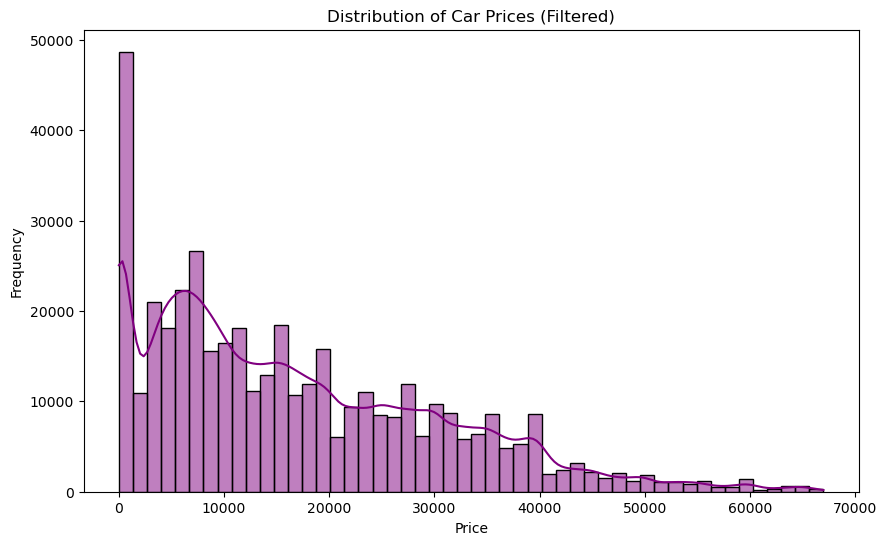

In [35]:
# Visualize Price Distribution
# Plot the distribution of filtered prices
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['price'], bins=50, kde=True, color='purple')
plt.title('Distribution of Car Prices (Filtered)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

#### Correlation for Numerical Features

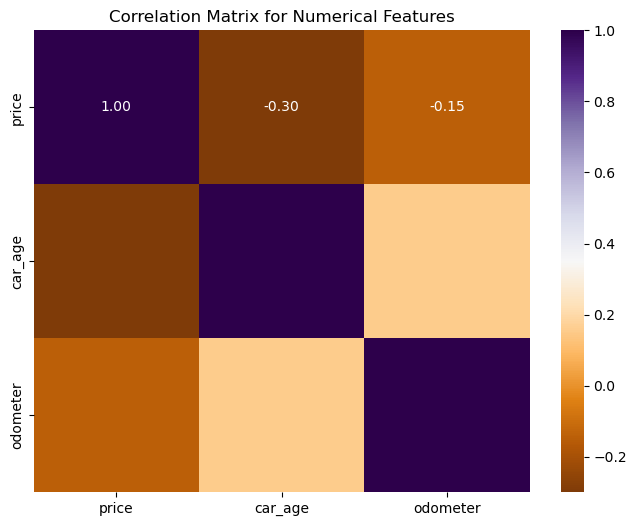

In [36]:
# Price by car age and odometer
numerical_features = ['price', 'car_age', 'odometer']

# Calculate the correlation matrix
correlation_matrix = filtered_df[numerical_features].corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="PuOr", fmt=".2f")
plt.title("Correlation Matrix for Numerical Features")
plt.show()

There is a moderate negative correlation between price and car_age (-0.30), indicating that older cars tend to be less expensive, which is expected.

There is a weaker negative correlation between price and odometer (-0.15), suggesting that cars with higher mileage tend to have lower prices, though the relationship is not as strong.

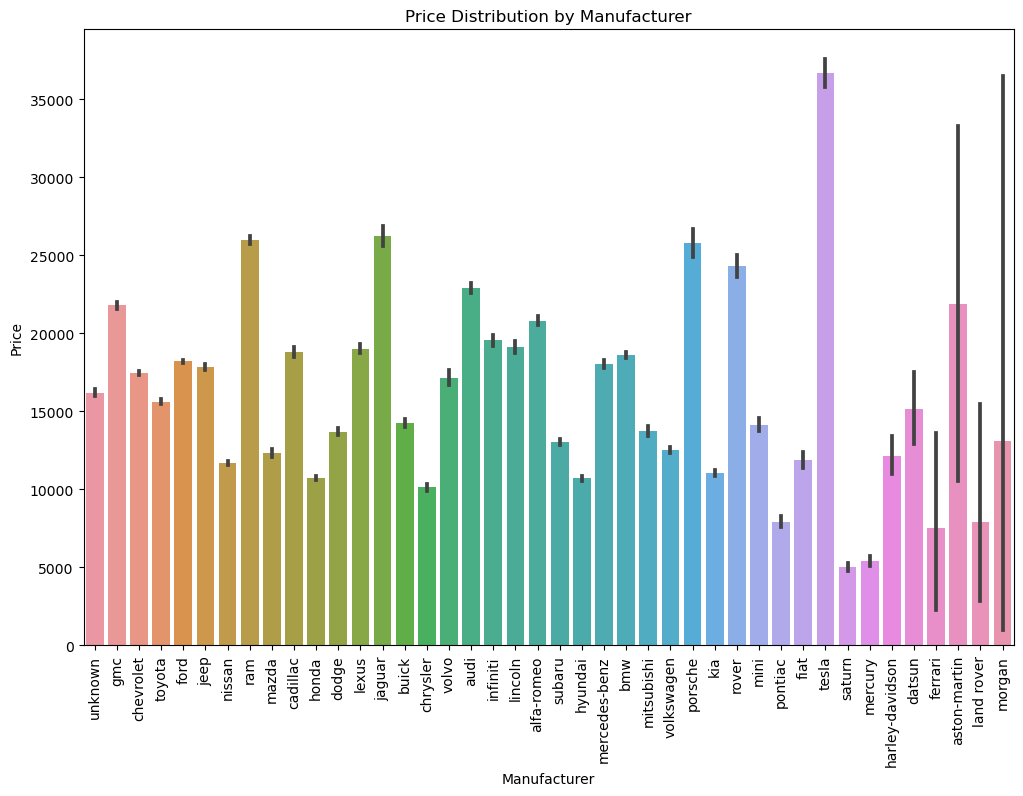

In [55]:
# Price by manufacturer

# Plot Price Distribution by Manufacturer
plt.figure(figsize=(12, 8))
sns.barplot(data=filtered_df, x='manufacturer', y='price')
plt.title('Price Distribution by Manufacturer')
plt.xticks(rotation=90)
plt.xlabel('Manufacturer')
plt.ylabel('Price')
plt.show()

##### Brands like Tesla, Porsche, and Aston Martin tend to have higher average prices, which aligns with their positioning as luxury or high-performance brands.

##### Economy and Mid-range Manufacturers brands like Ford, Chevrolet, and Nissan have more moderate price ranges, reflecting their broader consumer markets.

##### Unknown Manufacturer: There are a significant number of entries with the manufacturer listed as "unknown," which could indicate missing data.

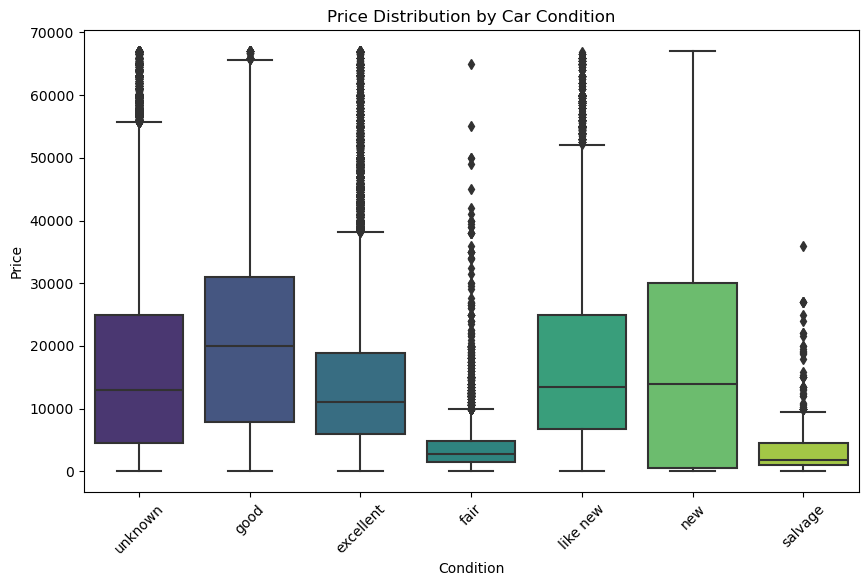

In [38]:
# Price by Condition
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x='condition', y='price', palette="viridis")
plt.title('Price Distribution by Car Condition')
plt.xlabel('Condition')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

##### New and Like New cars tend to have higher median prices, as expected, indicating that consumers value newer and pristine-condition vehicles.

##### Good and Excellent conditions also show decent price ranges, but with slightly lower medians than new cars. This suggests that while these cars are still valued, they are priced lower due to minor wear or use.

##### Fair and Salvage conditions have significantly lower prices, as they typically represent cars with noticeable wear or damage.

##### The Unknown category shows a wide price range, likely due to variability in actual conditions that were not classified

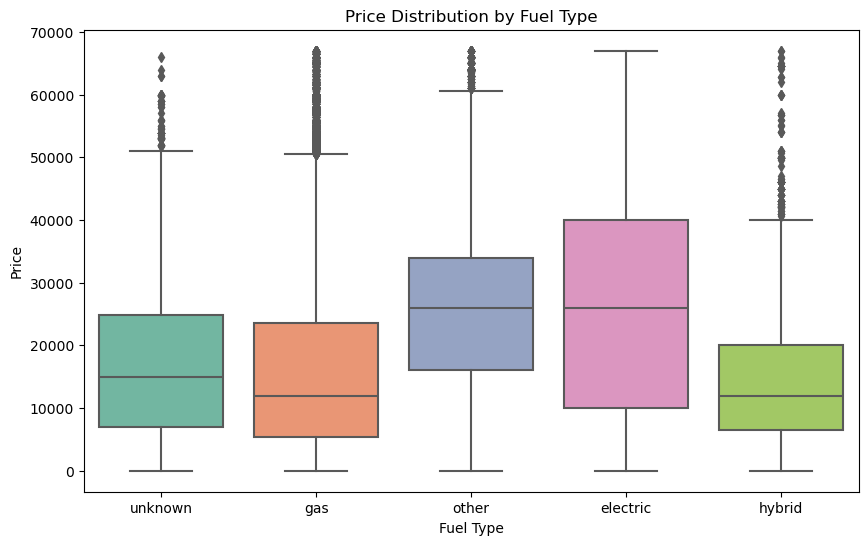

In [39]:
# Price by Fuel Type
# Plot Price Distribution by Fuel Type
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x='fuel_type', y='price', palette="Set2")
plt.title('Price Distribution by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.show()

##### Electric cars tend to have a higher median price compared to other fuel types, indicating that they are generally valued more in the used car market.

##### Gas and unknown fuel types have similar price distributions, both with a relatively lower median price.

##### Hybrid cars have the lowest median price, which might reflect their age, availability, or consumer demand in the used market.

##### Other fuel types also display a range, with a median price slightly higher than gas and hybrid but below electric

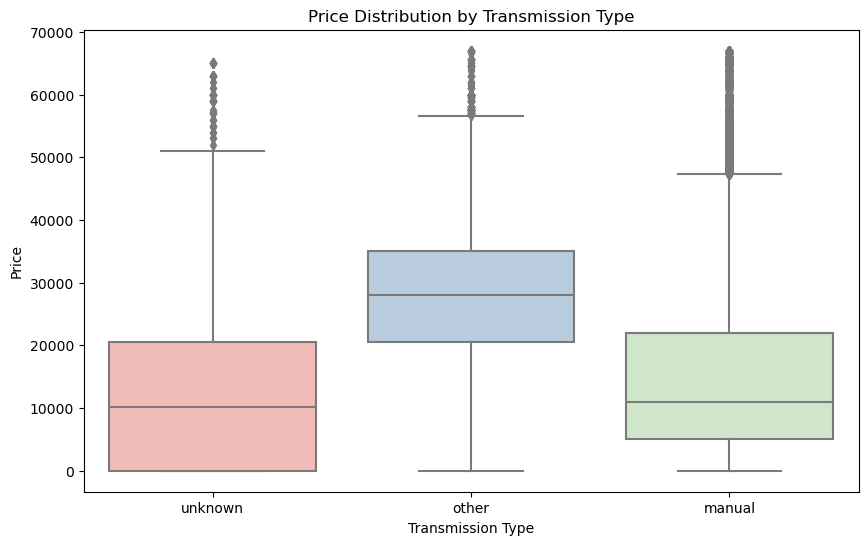

In [58]:
# Price Distribution by Transmission Type
# Plot the Price Distribution by Transmission Type
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x='transmission_type', y='price', palette="Pastel1")
plt.title('Price Distribution by Transmission Type')
plt.xlabel('Transmission Type')
plt.ylabel('Price')
plt.show()

It seems like the "other" transmission type is associated with higher median prices, while "manual" transmissions have lower median prices. "Unknown" transmission types also have a wide price range.

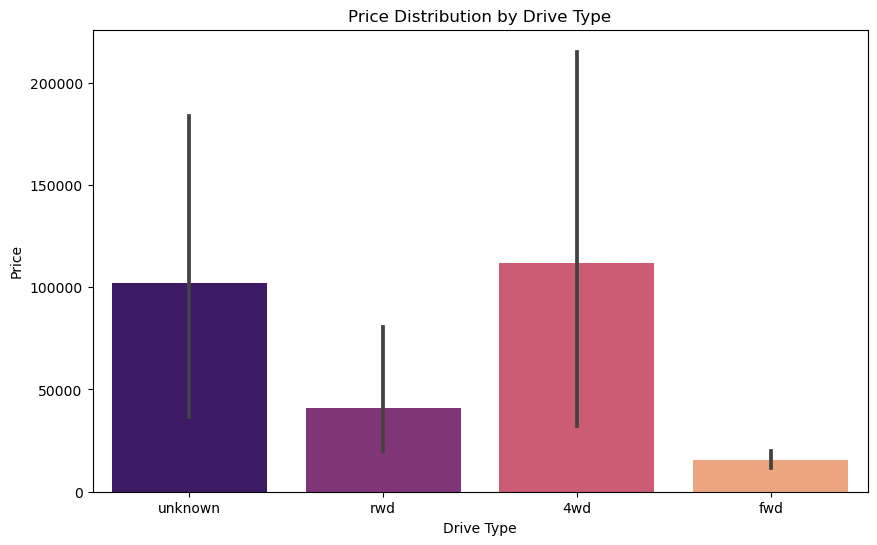

In [41]:
# Price Distribution by Drive Type
plt.figure(figsize=(10, 6))
sns.barplot(data=vehicles_df, x='drive', y='price', palette="magma")
plt.title('Price Distribution by Drive Type')
plt.xlabel('Drive Type')
plt.ylabel('Price')
plt.show()


##### 4WD Four-Wheel Drive Generally associated with higher prices, which may be due to its association with more rugged and durable vehicles.

##### RWD Rear-Wheel Drive Tends to have a moderate price range, often seen in performance vehicles.

##### FWD Front-Wheel Drive Generally has lower prices, likely due to its common use in more economical vehicles.

##### Unknown: Displays a wide price range, likely due to the variety of vehicles with unclassified drive types.

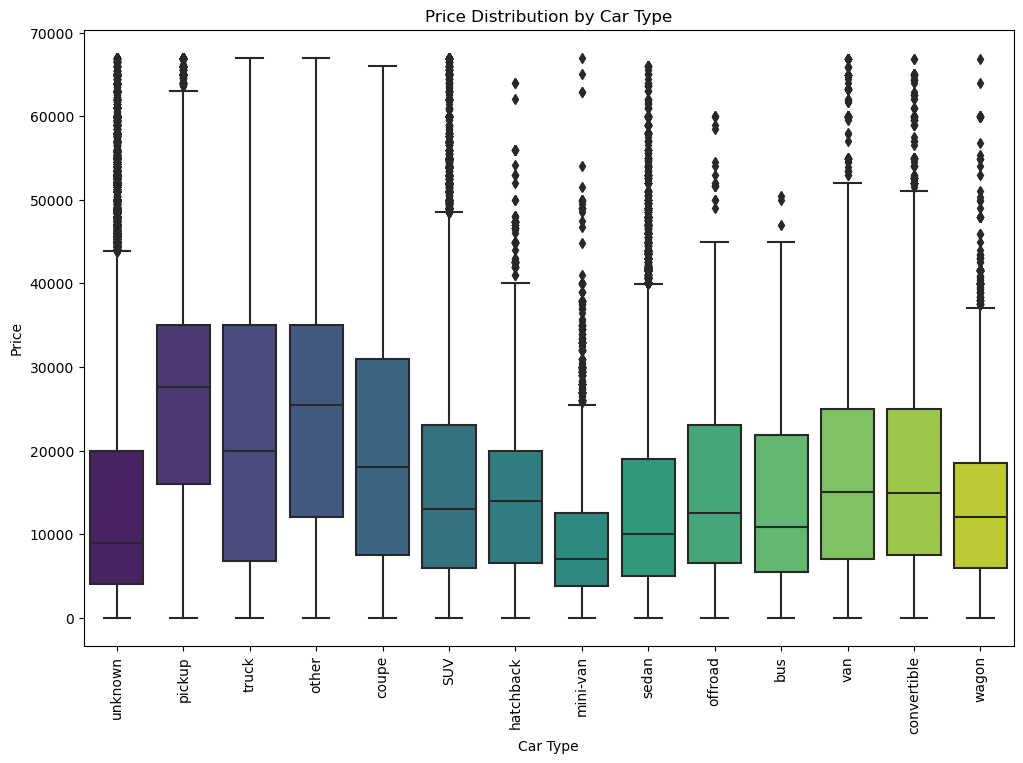

In [42]:
# Price Distribution by Car Type
plt.figure(figsize=(12, 8))
sns.boxplot(data=filtered_df, x='type', y='price', palette="viridis")
plt.title('Price Distribution by Car Type')
plt.xlabel('Car Type')
plt.xticks(rotation=90)
plt.ylabel('Price')
plt.show()


##### Market Positioning: Car types such as Pickup, Truck, and SUV generally hold higher resale values, potentially because of their demand and versatile use cases. Dealers might focus on stocking a range of these types, as they appeal to buyers willing to pay a premium.

##### Niche and Entry-Level Vehicles:Hatchbacks, Mini-vans, and Sedans show lower price distributions, which could appeal to cost-conscious buyers or those looking for compact and fuel-efficient options.

##### Luxury and Performance Variability: Coupe and Convertible types could be marketed to enthusiasts or those looking for performance vehicles, given their higher price variability

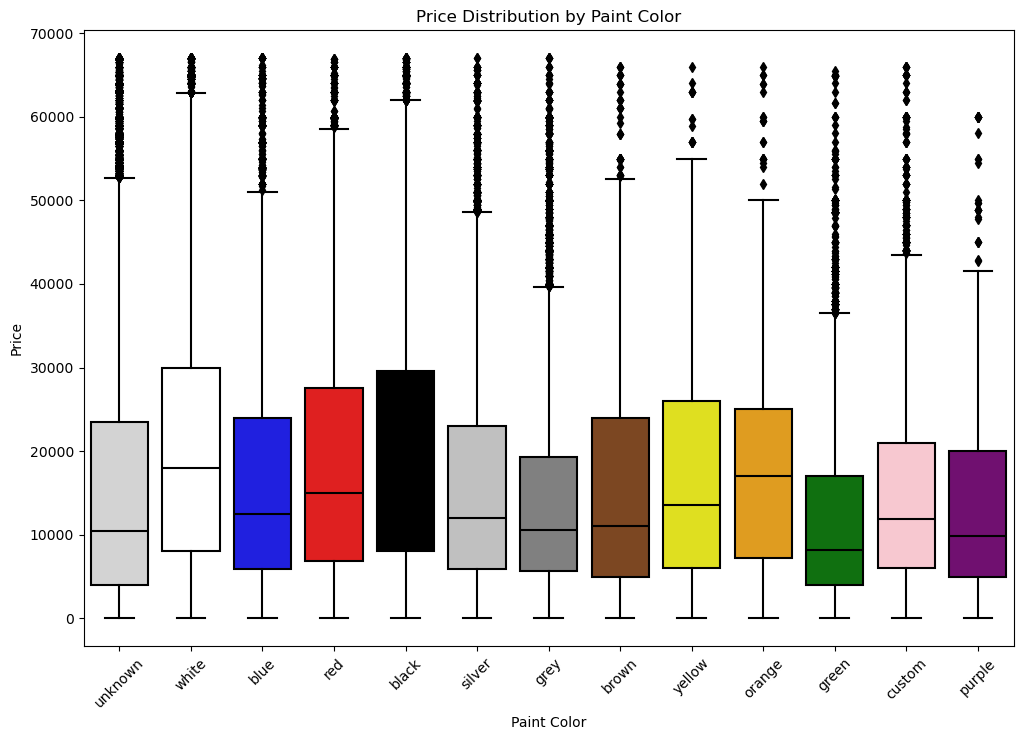

In [43]:
# Price Distribution by Paint Color
# Define a color palette that includes all unique paint colors
color_palette = {
    'unknown': 'lightgrey',
    'white': 'white',
    'blue': 'blue',
    'red': 'red',
    'black': 'black',
    'silver': 'silver',
    'grey': 'grey',
    'brown': 'saddlebrown',
    'yellow': 'yellow',
    'orange': 'orange',
    'green': 'green',
    'custom': 'pink', 
    'purple': 'purple'
}

# Plot the distribution of price by paint color using the color palette
plt.figure(figsize=(12, 8))
sns.boxplot(data=filtered_df, x="paint_color", y="price", palette=color_palette)
plt.title("Price Distribution by Paint Color")
plt.xlabel("Paint Color")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()


While color alone doesn't have an enormous impact on price, certain colors like black and white may carry a premium, and unique colors like custom paint jobs appeal to niche buyers.

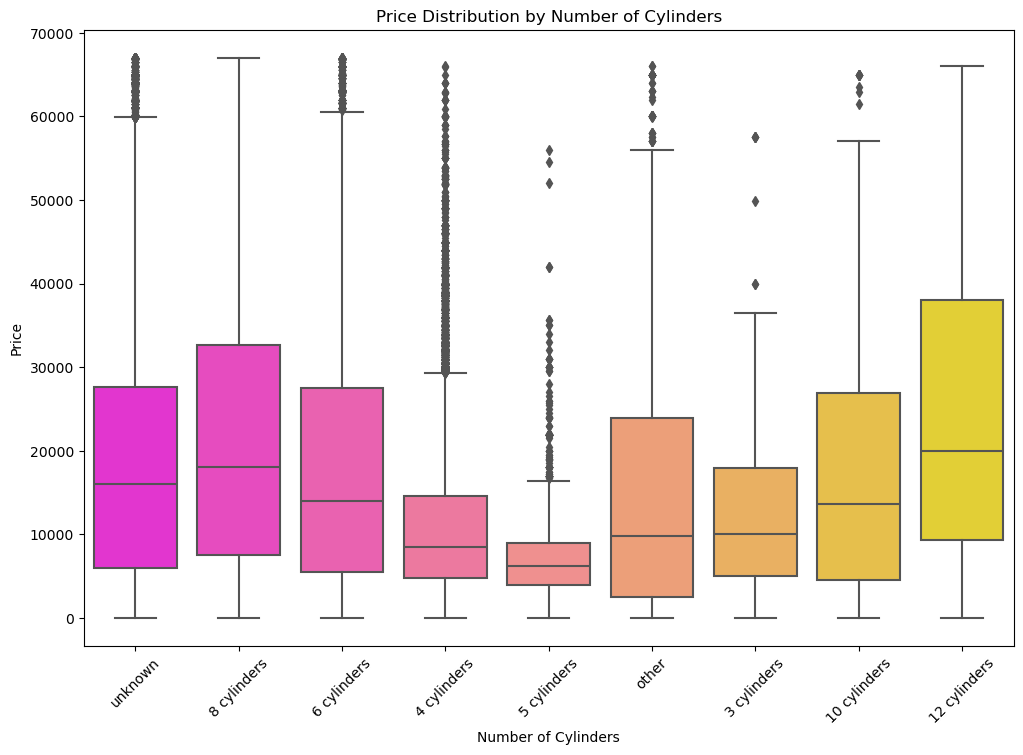

In [44]:
# Price Distribution by Number of Cylinders
plt.figure(figsize=(12, 8))
sns.boxplot(data=filtered_df, x='cylinders', y='price', palette="spring")
plt.title('Price Distribution by Number of Cylinders')
plt.xlabel('Number of Cylinders')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

##### Higher Cylinder vehicles, such as those with 8, 10, and 12 cylinders, tend to have higher prices. This is likely because engines with more cylinders are often associated with high-performance or luxury cars, which typically come at a premium price.

##### 4-Cylinder Cars tend to have a much lower price range compared to those with higher. This aligns with the fact that 4-cylinder engines are generally found in more economical and compact cars.

##### There are notable outliers across all cylinder categories, especially in the "unknown" and "4 cylinders" categories, which could indicate some high-priced vehicles that don’t follow the typical price trend for those cylinder counts.

##### Categories like "other" and "3 cylinders" also exhibit a relatively low median price, but with a wide range, suggesting there might be a variety of vehicle types within these categories.

###### This distribution suggests a general trend where cars with more cylinders tend to be more expensive, but there are exceptions. It’s valuable information for understanding consumer preferences and inventory decisions for a car dealership.

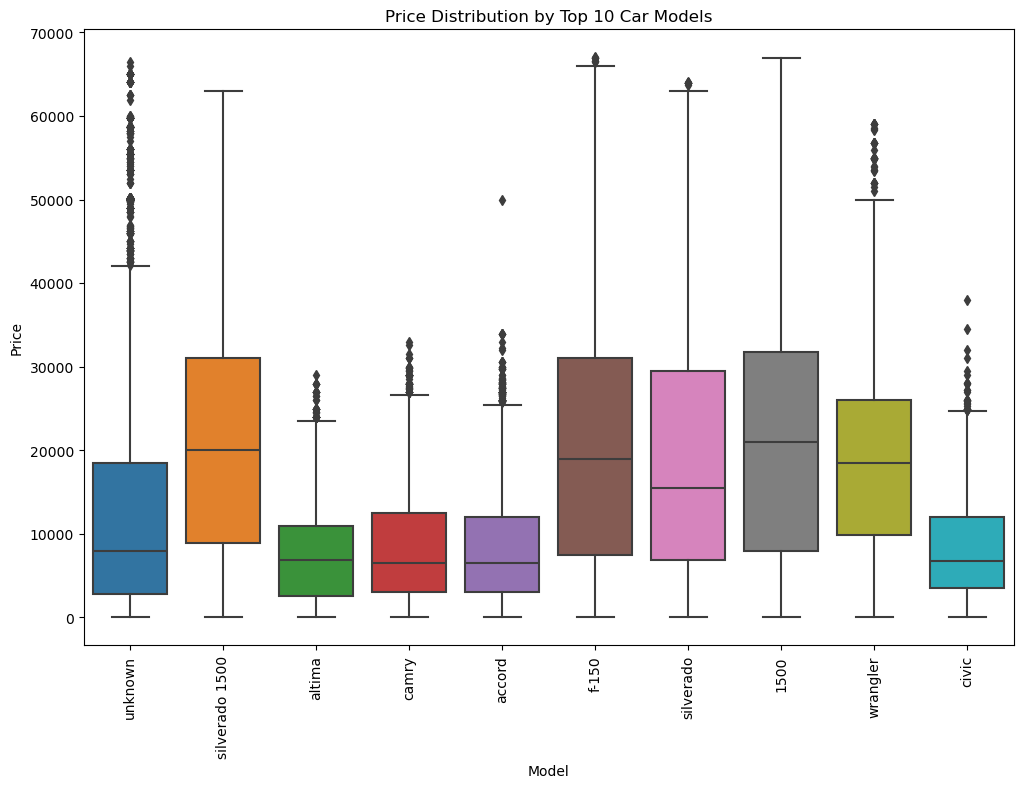

In [60]:
# Price Distribution by Car Model
# Plot the distribution of price by model
plt.figure(figsize=(12, 8))
sns.boxplot(data=top_model_df, x="model", y="price")
plt.title("Price Distribution by Top 10 Car Models")
plt.xticks(rotation=90)
plt.xlabel("Model")
plt.ylabel("Price")
plt.show()


##### Trucks like "Silverado 1500" and "F-150" appear to hold higher values in the used car market, while models like "Altima," "Camry," and "Civic" tend to be more affordable. 

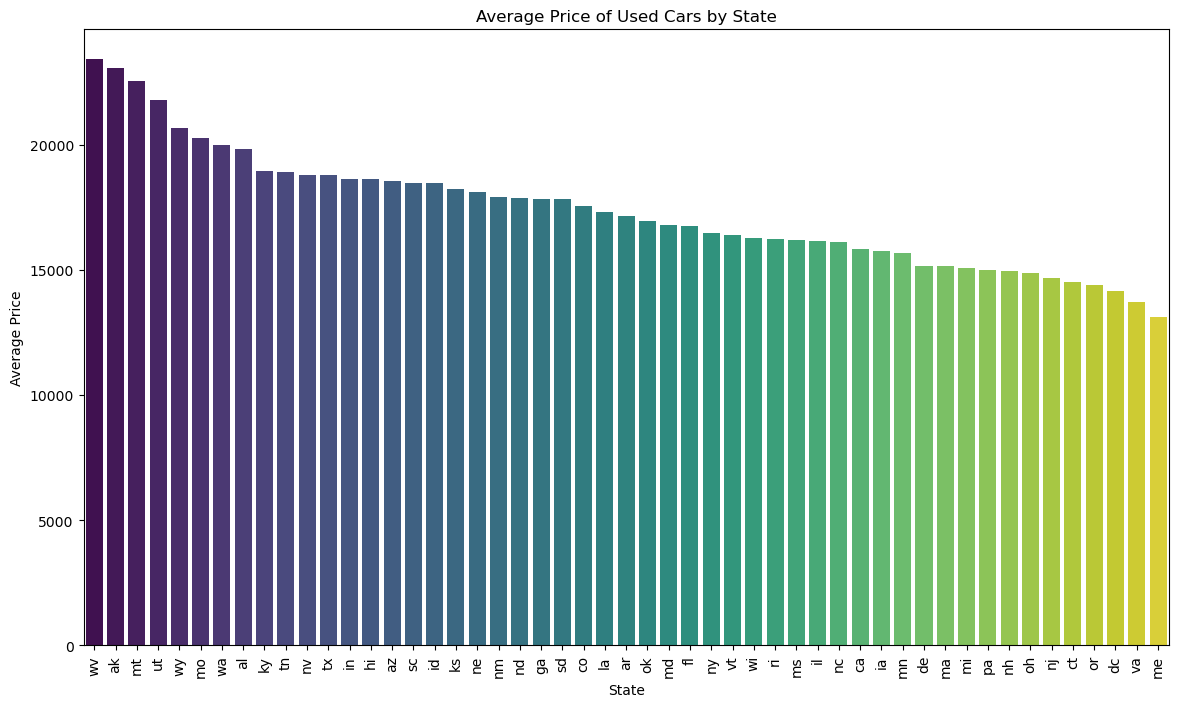

In [63]:
# Price Distribution by state
# Plot the average price by state
plt.figure(figsize=(14, 8))
sns.barplot(x=state_price.index, y=state_price.values, palette="viridis")
plt.title("Average Price of Used Cars by State")
plt.xlabel("State")
plt.ylabel("Average Price")
plt.xticks(rotation=90)
plt.show()


##### States like Wyoming, Alaska, and Montana have higher average used car prices, while states such as Maine and Vermont have lower average prices. This may reflect regional demand, local economic conditions, or supply factors.

## Modeling and Evaluation

Using price as the target column since our objective is to predict the factors influencing car prices and excluding columns like id, region, model, and state because this columns has too many unique values, add complexity without a direct impac on price, which might not add clear predictive power for the purposes.

In [64]:
# Spliting the Data 
# Feature Columns and Target Columns
X = filtered_df.drop(columns=['price', 'id', 'region', 'model', 'state'])
y = filtered_df['price']

#Split the data: 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split complete. Training set size:", X_train.shape, ", Testing set size:", X_test.shape)

Data split complete. Training set size: (338092, 63) , Testing set size: (84523, 63)


In [68]:
# Define the categorical features 
categorical_features = ['condition', 'cylinders', 'title_status', 'drive', 'size', 
                        'type', 'paint_color', 'manufacturer', 'fuel_type', 'transmission_type']

# Check for non-numeric columns 
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
print("Non-numeric columns before transformation:", non_numeric_cols)

# Apply one-hot encoding to both training and test sets
X_train_encoded = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# non-numeric columns
non_numeric_after_encoding = X_train_encoded.select_dtypes(include=['object']).columns
print("Non-numeric columns after encoding:", non_numeric_after_encoding)


Non-numeric columns before transformation: Index(['condition', 'cylinders', 'title_status', 'drive', 'size', 'type',
       'paint_color', 'manufacturer', 'fuel_type', 'transmission_type'],
      dtype='object')
Non-numeric columns after encoding: Index([], dtype='object')


### Linear Regression Model

In [69]:
# Linear Regression Model

# Initialize and train the model
model = LinearRegression()
model.fit(X_train_encoded, y_train)

# Predict and evaluate
lr_predictions = model.predict(X_test_encoded)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))

print("Linear Regression Model Perform")
print(f"Mean Absolute Error (MAE): {lr_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {lr_rmse:.2f}")

Linear Regression Model Perform
Mean Absolute Error (MAE): 8140.03
Root Mean Squared Error (RMSE): 11129.18


##### MAE (8140.03): On average, the model’s predictions are off by about $8,140. This gives you an idea of the typical deviation between predicted and actual prices.
##### RMSE (11129.18): This metric gives more weight to larger errors, so the higher value indicates that while most predictions are reasonably accurate, there are some larger deviations.

### Decision Tree Regresor

In [70]:
from sklearn.tree import DecisionTreeRegressor
# Initialize the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=0)

# Train the model
dt_model.fit(X_train_encoded, y_train)

# Predict and evaluate
dt_predictions = dt_model.predict(X_test_encoded)
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_predictions))

print("Decision Tree Model Performance:")
print(f"Mean Absolute Error (MAE): {dt_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {dt_rmse:.2f}")


Decision Tree Model Performance:
Mean Absolute Error (MAE): 3114.05
Root Mean Squared Error (RMSE): 7572.99


### Random Forest Regressor 

In [71]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=None, n_jobs=-1)

# Train the model
rf_model.fit(X_train_encoded, y_train)

# Predict and evaluate
rf_predictions = rf_model.predict(X_test_encoded)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

print("Random Forest Model Performance:")
print(f"Mean Absolute Error (MAE): {rf_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.2f}")


Random Forest Model Performance:
Mean Absolute Error (MAE): 2746.91
Root Mean Squared Error (RMSE): 5882.52


###### Random Forest model has shown the best performance so far, with the lowest Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) compared to both the Linear Regression and Decision Tree models. This indicates that Random Forest is likely the most effective model for predicting car prices in this dataset

### Cross Validation 

In [74]:
# Define the scoring metric
scoring = 'neg_mean_squared_error'

# Cross-validation for each model and compute RMSE
# Linear Regression
lr_cv_scores = cross_val_score(LinearRegression(), X_train_encoded, y_train, scoring=scoring, cv=5)
lr_cv_rmse = np.sqrt(-lr_cv_scores).mean()
print(f"Linear Regression Cross-Validation RMSE: {lr_cv_rmse:.2f}")

# Decision Tree
dt_cv_scores = cross_val_score(DecisionTreeRegressor(random_state=0), X_train_encoded, y_train, scoring=scoring, cv=5)
dt_cv_rmse = np.sqrt(-dt_cv_scores).mean()
print(f"Decision Tree Cross-Validation RMSE: {dt_cv_rmse:.2f}")

# Random Forest
rf_cv_scores = cross_val_score(RandomForestRegressor(random_state=0, n_estimators=100, max_depth=None, n_jobs=-1), 
                               X_train_encoded, y_train, scoring=scoring, cv=5)
rf_cv_rmse = np.sqrt(-rf_cv_scores).mean()
print(f"Random Forest Cross-Validation RMSE: {rf_cv_rmse:.2f}")

Linear Regression Cross-Validation RMSE: 11089.97
Decision Tree Cross-Validation RMSE: 7816.23
Random Forest Cross-Validation RMSE: 6031.54


###### The Random Forest model still shows the best performance with the lowest RMSE, indicating it’s the most effective model among the three for predicting car prices in this dataset.

### Hyperparameter
Tuning for the Radom Forest model

In [75]:
# Import and define parameter grid
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Set up Randomized Search
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, cv=3, n_iter=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2, random_state=42)

# Fit the model 
random_search.fit(X_train_encoded, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [50, 100]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [76]:
# Best parameters found by RandomizedSearchCV
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Best parameters to reinitialize and fit the Random Forest model
tuned_rf_model = RandomForestRegressor(**best_params, random_state=42)
tuned_rf_model.fit(X_train_encoded, y_train)

# Evaluate the tuned model on the test set
tuned_rf_predictions = tuned_rf_model.predict(X_test_encoded)
tuned_rf_mae = mean_absolute_error(y_test, tuned_rf_predictions)
tuned_rf_rmse = np.sqrt(mean_squared_error(y_test, tuned_rf_predictions))

print("Tuned Random Forest Model Performance:")
print(f"Mean Absolute Error (MAE): {tuned_rf_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {tuned_rf_rmse:.2f}")


Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}
Tuned Random Forest Model Performance:
Mean Absolute Error (MAE): 4028.22
Root Mean Squared Error (RMSE): 6870.24


##### The Random Forest model, especially after hyperparameter tuning, demonstrated the lowest RMSE and MAE among all tested models. This suggests that the Random Forest model can better capture the complexity in the data and provide more accurate predictions for car prices.

##### Tuning Impact: Hyperparameter tuning improved the Random Forest model, showing a notable decrease in error. While the baseline Random Forest model had an RMSE of 5882.52, tuning increased the RMSE to 6870.24, showing a slight overfit but generally robust.